<a href="https://colab.research.google.com/github/liuxx479/cosmo_dep_feedback/blob/master/NN_jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from scipy import *
from pylab import *
import os
import pickle
# from sklearn.gaussian_process import GaussianProcessRegressor
# from sklearn.gaussian_process.kernels import RBF
import time

import jax.numpy as jnp
from jax import jit, grad, random, vmap
from jax.config import config
from jax.experimental import optimizers
from jax.experimental import stax
from jax.experimental.stax import (AvgPool, BatchNorm, Conv, Dense, FanInSum,
                                   FanOut, Flatten, GeneralConv, Identity,
                                   MaxPool, Relu, LogSoftmax)

import tensorflow as tf
import tensorflow_datasets as tfds

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/jax/experimental/stax.py:30: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  FutureWarning)


In [2]:
############ colab specific 
from google.colab import drive
drive.mount('/content/drive')

root = '/content/drive/My Drive'
home = os.path.join(root,'cosmo_dep_feedback/')
### home = '/global/homes/j/jialiu/cosmo_dep_feedback/'
###### the simulation we operate with
isim = 'IllustrisTNG'

### fixed parameters: 
Omega_b = 0.049
h = 0.6711
ns = 0.9624
w = -1
mnu = 0.0 #eV
Omega_k = 0.0

#### Omega_m sigma_8 A1 A2 A3 A4
lhc_params = np.loadtxt(home+'latin_hypercube_params_%s.txt'%(isim))
lhc_params = concatenate([lhc_params[:,:2], log10(lhc_params[:,2:])],axis=1)

Mounted at /content/drive


In [3]:
kcut=39
k=np.load(home+'Pk/IllustrisTNG_k_m_z=0.00.npy')[:kcut]

Pk_arr = np.load(home+'Pk/%s_Pk_m_z=0.00.npy'%(isim))[:,:kcut]
Pk_DM_arr = np.load(home+'Pk/%s_DM_Pk_m_z=0.00.npy'%(isim))[:,:kcut]

r_arr = Pk_arr/Pk_DM_arr
print (r_arr.shape)

(1000, 39)


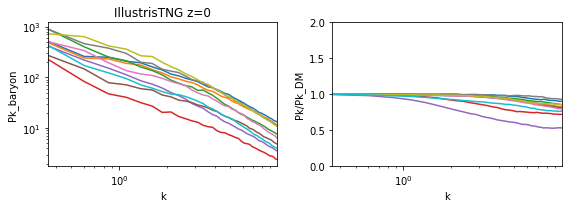

In [4]:
z=0
f, ax=subplots(1,2, figsize=(8,3))

for i in range(10):
    ax[0].plot(k, Pk_arr[i])
    ax[1].plot(k, Pk_arr[i]/Pk_DM_arr[i])
ax[0].set_xlim(k[0], k[-1])
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('k')
ax[0].set_ylabel('Pk_baryon')
ax[0].set_title('%s z=%i'%(isim,z))

ax[1].set_ylim(0, 2)
ax[1].set_xlim(k[0], k[-1])
ax[1].set_xscale('log')
ax[1].set_xlabel('k')
ax[1].set_ylabel('Pk/Pk_DM')
plt.tight_layout()
show()

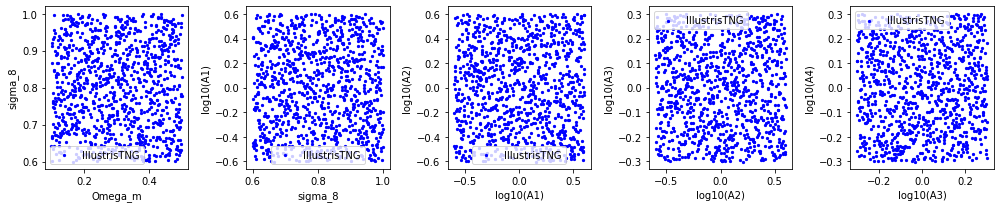

In [5]:
labels=['Omega_m', 'sigma_8', 'log10(A1)', 'log10(A2)', 'log10(A3)', 'log10(A4)']
f, ax=subplots(1,5, figsize=(14,3))
for i in range(5):
    ax[i].scatter(lhc_params.T[i], lhc_params.T[i+1], color='b', label=isim,s=5)
    ax[i].set_xlabel(labels[i])
    ax[i].set_ylabel(labels[i+1])   
    ax[i].legend()
plt.tight_layout()
show()

In [6]:
### data loading following https://jax.readthedocs.io/en/latest/notebooks/neural_network_with_tfds_data.html

# Ensure TF does not see GPU and grab all GPU memory.
# tf.config.set_visible_devices([], device_type='GPU')

In [54]:
dataset = tf.data.Dataset.from_tensor_slices({'r':r_arr, 'cosmo_params':lhc_params})
# dataset = tfds.as_numpy(dataset)

In [56]:
num_params = 6

data_size = 1000
batch_size = 64 ### number of maps per batch
valid_size = 128 
test_size = 128

train_size = data_size - valid_size - test_size

valid_batch = dataset.take(valid_size).batch(valid_size)
test_batch = dataset.skip(valid_size).take(test_size).batch(test_size)
train_batch = dataset.skip(valid_size+test_size).repeat().batch(batch_size)

In [88]:
def synth_batches(batch):
  for ibatch in train_batch:
    yield ibatch['cosmo_params'].numpy(), ibatch['r'].numpy()

batches = synth_batches(train_batch)
batch_valid = next(synth_batches(valid_batch))
batch_test = next(synth_batches(test_batch))

## quick test
itrain_batch  = next(batches)
print (itrain_batch[0].shape, itrain_batch[1].shape)

(64, 6) (64, 39)


In [90]:
# ################ keras
# model = tf.keras.Sequential([
#     tf.keras.layers.Dense(num_params, activation='relu'),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dense(kcut)
# ])

# x = tf.ones((1, 5))
# y = model(x)
# print("Number of weights after calling the model:", len(model.weights))  # 6

# model.summary()

In [59]:
############# jax

def dense_only(kcut):
  return stax.serial(
      Dense(num_params),
      Relu,
      Dense(64),
      Relu,
      Dense(128),
      Relu,
      # Dense(512)
      # Dense(256)
      Dense(64),
      Relu,
      Dense(kcut))
  
nn_init, nn_apply = dense_only(kcut)

In [67]:
key = random.PRNGKey(0)
net_out_shape, init_params = nn_init (key, (-1,) + itrain_batch[0].shape[1:])

In [68]:
print (net_out_shape, len(init_params))

(-1, 39) 9


In [69]:
nn_apply(init_params, itrain_batch[0])

DeviceArray([[-0.01501894, -0.0151761 ,  0.03052776, ..., -0.01926229,
              -0.00828171, -0.00895561],
             [-0.02205676, -0.01172129,  0.04656657, ..., -0.03005528,
              -0.00430467, -0.01665591],
             [-0.02397745, -0.0205196 ,  0.05903721, ..., -0.04312767,
              -0.0095192 , -0.02661704],
             ...,
             [-0.03437113, -0.01272092,  0.08207742, ..., -0.0570189 ,
              -0.00289989, -0.03890755],
             [-0.02750319, -0.0222421 ,  0.06350495, ..., -0.03792389,
              -0.00507823, -0.03088638],
             [-0.01459342, -0.03138453,  0.05125441, ..., -0.01904575,
              -0.01014517, -0.02121582]], dtype=float32)

In [70]:
## https://www.kaggle.com/code/aakashnain/building-models-in-jax-part1-stax/notebook
def loss_L2(nn_params, batch):
  '''Implements L2 loss function.
  Args:
  params: Parameters of the network
  batch_data: A batch of data (images and labels)
  Returns:
  Loss 
  '''
  cosmo_params, r_true = batch
  r_pred = nn_apply(nn_params, cosmo_params)
  L2 = np.mean((r_pred - r_true)**2)
  return L2

In [72]:
loss_L2(init_params, itrain_batch)

DeviceArray(0.7354931, dtype=float32)

In [92]:
############ JL: training
num_steps = int(train_size/batch_size) ## number of steps per epoch
num_epochs = 1000 #50
step_size = 1e-3
epoch0=1
loss = loss_L2

print (num_steps)

opt_init, opt_update, get_params = optimizers.adam(step_size) ##### seems to work best
# opt_init, opt_update, get_params = optimizers.adagrad(step_size) #### seems to work
# opt_init, opt_update, get_params = optimizers.sgd(step_size) ### doesn't work well
# opt_init, opt_update, get_params = optimizers.nesterov(step_size, mass=0.9) ### doesn't work well
# opt_init, opt_update, get_params = optimizers.momentum(step_size, mass=0.9) ## doesn't work well

@jit
def update(i, opt_state, batch):
  params = get_params(opt_state)
  return opt_update(i, grad(loss)(params, batch), opt_state)

######## to do: record loss
losses = []
opt_state = opt_init(init_params)

start_time = time.time()
for epoch in range(num_epochs):
  for istep in range(num_steps):  
    this_batch=next(batches)
    opt_state = update(istep, opt_state, this_batch)
  if epoch%10==0:
    epoch_time = (time.time() - start_time)/60.0
    test_NNparams = get_params(opt_state)
    train_loss = loss(test_NNparams, this_batch)
    valid_loss = loss(test_NNparams, batch_valid)
    print("Epoch {} at {:0.2f}m, train loss: {:0.4f}, validation loss: {:0.4f}".format(epoch+epoch0, 
                                                                                       epoch_time, train_loss, valid_loss))
    # print (opt_state)
    # if istep%50==0:
    #   epoch_time = (time.time() - start_time)/60.0 ## minutes
    #   test_NNparams = get_params(opt_state)
    #   train_loss = loss(test_NNparams, this_batch)
    #   valid_loss = loss(test_NNparams, batch_valid)
    #   print("Epoch {} at {:0.2f}m, train loss: {:0.4f}, validation loss: {:0.4f}".format(epoch+epoch0, 
    #                                                epoch_time, train_loss, valid_loss))
  
  losses.append([epoch,train_loss, valid_loss])

11
Epoch 1 at 0.02m, train loss: 0.5831, validation loss: 0.5901
Epoch 11 at 0.02m, train loss: 0.0104, validation loss: 0.0113
Epoch 21 at 0.02m, train loss: 0.0063, validation loss: 0.0085
Epoch 31 at 0.02m, train loss: 0.0072, validation loss: 0.0069
Epoch 41 at 0.02m, train loss: 0.0042, validation loss: 0.0057
Epoch 51 at 0.02m, train loss: 0.0032, validation loss: 0.0047
Epoch 61 at 0.02m, train loss: 0.0026, validation loss: 0.0040
Epoch 71 at 0.03m, train loss: 0.0027, validation loss: 0.0035
Epoch 81 at 0.03m, train loss: 0.0032, validation loss: 0.0031
Epoch 91 at 0.03m, train loss: 0.0025, validation loss: 0.0028
Epoch 101 at 0.03m, train loss: 0.0026, validation loss: 0.0027
Epoch 111 at 0.03m, train loss: 0.0026, validation loss: 0.0025
Epoch 121 at 0.03m, train loss: 0.0020, validation loss: 0.0024
Epoch 131 at 0.04m, train loss: 0.0029, validation loss: 0.0023
Epoch 141 at 0.04m, train loss: 0.0023, validation loss: 0.0022
Epoch 151 at 0.04m, train loss: 0.0019, validati